# Building Decsion Tree from scratch

* Both classfification & Regression 
* puned decision tree

In [266]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import matplotlib.pyplot as plt

In [248]:
df = pd.read_csv("processed.cleveland.data", header=None)

In [249]:
df.columns = [
    'age',
    'sex',
    'cp',
    'restbp',
    'chol',
    'fbs',
    'restecg',
    'thalach',
    'exang',
    'oldpeak',
    'slope',
    'ca',
    'thal',
    'hd'
]

In [250]:
#df.head()

In [251]:
# df.isnull().sum()

In [252]:
#df.dtypes

In [253]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

In [254]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

In [255]:
df = df.loc[(df['ca'] != '?') & (df['thal'] != '?')]

### prepare the data and train test split

Scikit learn does not natively support categorical data?

In [256]:
X = df.drop('hd', axis=1).copy()
y = df['hd'].copy()

In [257]:
# get dummies of these categories variables
X = pd.get_dummies(X, columns=['cp','restecg','slope','thal'])

In [258]:
y = y.map(lambda x: 0 if x ==0 else 1)

In [259]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

### model build

In [260]:
dc = DecisionTreeClassifier(random_state=42)
dc.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

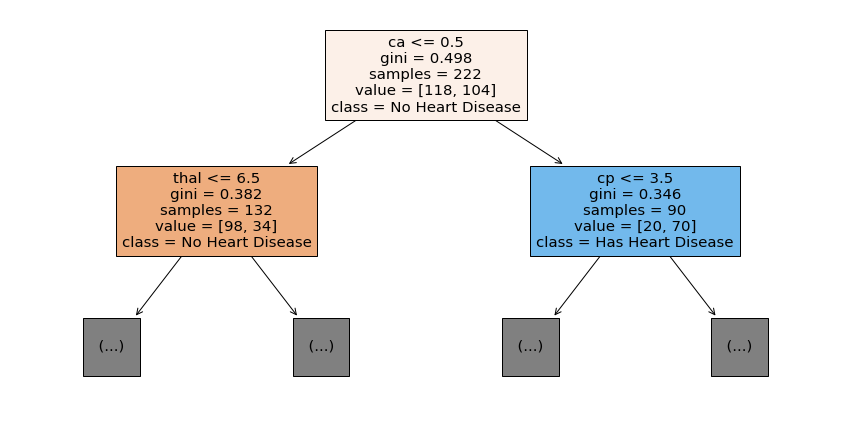

In [177]:
plt.figure(figsize=(15,7.5))
plot_tree(dc,max_depth=1,filled=True, class_names=["No Heart Disease",'Has Heart Disease'],
         feature_names=X.columns);

#plt.savefig('tree_plot2', dpi=500,format='eps')

In [240]:
# calculate the Gini Impurity manually

# df_first_node_smaller = df.loc[df['ca'] <= 0.5].copy()
# df_first_node_larger = df.loc[df['ca'] <= 0.5].copy()

def cal_gini_num(df, num_variable, target):
           
    unique_var = df[num_variable].unique().tolist()
    unique_var.sort()
    means = []
    for q in range(len(unique_var)-1):
        means.append((unique_var[q] + unique_var[q+1])/2)
        
    result_gini = 1
    best_mean = 0
    leftnode_gini = 0
    rightnode_gini = 0
    
    for each_mean in means:
        df1 = df.loc[df[num_variable] <= each_mean].copy()
        df2 = df.loc[df[num_variable] > each_mean].copy()
        
        
        df1_por = df1[target].value_counts(normalize=True)
        df1_gini = 1 - sum([i**2 for i in df1_por])
            
        df2_por = df2[target].value_counts(normalize=True)
        df2_gini = 1 - sum([i**2 for i in df2_por])
        
        total_gini = len(df1)/len(df)*df1_gini + len(df2)/len(df)*df2_gini
        
        if total_gini < result_gini:
            result_gini = total_gini
            best_mean = each_mean
            leftnode_gini = df1_gini
            rightnode_gini = df2_gini

    print(f'When split by ca <= {best_mean} the next 2 nodes have smallest total gini impurity {result_gini}\n',
         f'Gini impurity of left node is {leftnode_gini}\n',
         f'Gini impurity of right node is {rightnode_gini}')    

In [241]:
gini_test_df = pd.concat([X_train,y_train], axis=1)
gini_test_df['ca'] = pd.to_numeric(gini_test_df['ca'])

In [242]:
cal_gini_num(gini_test_df,'ca','hd')

When split by ca <= 0.5 the next 2 nodes have smallest total gini impurity 0.3675493675493676
 Gini impurity of left node is 0.38246097337006435
 Gini impurity of right node is 0.345679012345679


![](./tree_plot_1st.png)

### My manually calculated impurities are same as the sklearn calculated ones.

---

## Cost Complexity Pruning

In [262]:
path = dc.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

dc_list = []

for ccp_alpha in ccp_alphas:
    new_dc = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    new_dc.fit(X_train, y_train)
    dc_list.append(new_dc)

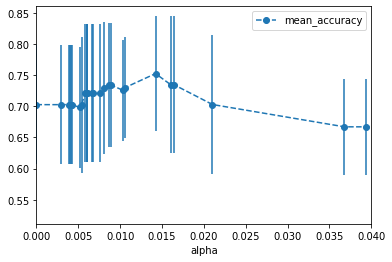

In [271]:
alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    new_dc = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    scores = cross_val_score(new_dc, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha','mean_accuracy','std'])

alpha_results.plot(x='alpha',
                  y = 'mean_accuracy',
                  yerr='std',
                  marker='o',
                  linestyle='--');
plt.xlim((0,0.040));
plt.xticks([0.000, 0.005,0.010,0.015,0.020,0.025,0.030,0.035,0.040]);

### Ideal alpha is around 0.014

In [289]:
# find the exact alpha by selecting the alpha with the largeset mean_accuracy
alpha_results = alpha_results.sort_values(by='mean_accuracy', ascending=False).reset_index(drop=True)
best_alpha = alpha_results.loc[0,'alpha']
best_alpha

0.014224751066856332

### build a new tree base on the best ccp

In [294]:
new_dc = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
new_dc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.014224751066856332, random_state=42)

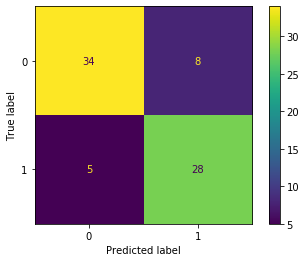

In [302]:
plot_confusion_matrix(new_dc, X_test,y_test);

## compare with the previous one which wasn't been pruned

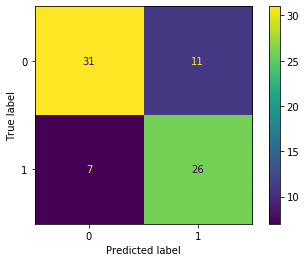

In [299]:
plot_confusion_matrix(dc, X_test, y_test);

## Compare the sensitivity and specificity

In [304]:
# function calculate sensitivity (True Positive Rate)
def cal_sensitivity(TP, FN):
    return(TP/(TP+FN))

# function calculate specificity (True Negative Rate)
def cal_specificity(TN, FP):
    return(TN/(TN+FP))

In [307]:
new_TPR, new_TNR = cal_sensitivity(34,8), cal_specificity(28,5)
TPR, TNR = cal_sensitivity(31,11), cal_specificity(26,7)

print(f'Sensitivity for pruned decision tree is {new_TPR}, \n for un-pruned decision tree is {TPR}\n','\n',
     f'Specificity for pruned decision tree is {new_TNR}, \n for un_pruned decision tree is {TNR}')

Sensitivity for pruned decision tree is 0.8095238095238095, 
 for un-pruned decision tree is 0.7380952380952381
 
 Specificity for pruned decision tree is 0.8484848484848485, 
 for un_pruned decision tree is 0.7878787878787878


### By comparing sensitivity and specificity we clearly see that pruned decision tree is much better